In [1]:
import sys
import pandas as pd
sys.path.insert(0, "../")

from michael import janet

Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

In [3]:
j = janet.boot(uni, index=259)

In [4]:
j

Hi there! I'm Janet 🌵
I don't have any data or results in storage right now. Try running `janet.prepare_data()` to get started! ✨

In [5]:
j.prepare_data()

Already have data loaded for Gaia ID 2227100384482274048.
If you want to check for new data, run `janet.Update()`.


In [6]:
period_range = (5, 8)
j.get_rotation()

### Running Simple Astropy Lomb-Scargle on Sector 17 on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector 17 on star 2227100384482274048 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 18 on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector 18 on star 2227100384482274048 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 24 on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector 24 on star 2227100384482274048 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 25 on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector 25 on star 2227100384482274048 ###
### Saved results ###
### Running Wavelet Estimation on star 2227100384482274048 ###


/Users/Anaconda/anaconda3/lib/python3.8/site-packages/jazzhands/wavelets.py:488: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



### Completed Wavelet Estimation on star 2227100384482274048 ###
### Saved results ###


In [12]:
j.void

{'datum_17': <eleanor.targetdata.TargetData at 0x7ffb3672f880>,
 'clc_17': <LightCurve length=957>
        time               flux        flux_err
                                               
       object            float64       float64 
 ------------------ ------------------ --------
  1764.700607169331 1.0030048361556831      nan
  1764.721481131371 1.0004478388394416      nan
 1764.7422940593656 1.0027888679480381      nan
 1764.7631069900192 1.0038195698358996      nan
 1764.8047938958382 1.0023637615634653      nan
 1764.8256068345875 1.0014667848003584      nan
 1764.8464808124847  1.001466421820607      nan
 1764.8672937566255 1.0021673860376028      nan
 1764.8881067034208 1.0027762470198052      nan
                ...                ...      ...
 1788.9508864908594 0.9931634538720242      nan
   1788.97176052348 0.9911168193198715      nan
 1788.9925735202085 0.9935805666428803      nan
  1789.055073539553 0.9896155325586731      nan
 1789.0967605572353 0.996758157626576

In [13]:
j.results

,SLS,e_SLS,f_SLS,SW,e_SW
17,5.422369,0.453605,0.0,NaN,NaN
18,4.258454,0.425845,3.0,NaN,NaN
24,7.831243,0.783124,0.0,NaN,NaN
25,9.407179,1.264164,0.0,NaN,NaN
all,NaN,NaN,NaN,8.664236,2.198223


In [11]:
import numpy as np
any(np.diff([15]) > 1)

False

In [7]:
j

Hi there! I'm Janet 🌵

In [14]:
j.results

,SLS,e_SLS,f_SLS,SW,e_SW
17,5.422369,0.453605,0.0,NaN,NaN
18,4.258454,0.425845,3.0,NaN,NaN
24,7.831243,0.783124,0.0,NaN,NaN
25,9.407179,1.264164,0.0,NaN,NaN
all,NaN,NaN,NaN,8.664236,2.198223


In [17]:
j.results[j.results['f_SLS'] == 0]

,SLS,e_SLS,f_SLS,SW,e_SW
17,5.422369,0.453605,0.0,NaN,NaN
24,7.831243,0.783124,0.0,NaN,NaN
25,9.407179,1.264164,0.0,NaN,NaN


In [35]:
j.results.loc['best', 'SLS'] = 5.442
j.results.loc['best', 'e_SLS'] = 0.453
j.results.loc['best', 'SW'] = 8.66
j.results.loc['best', 'e_SW'] = 2.20

In [63]:
j.results

,SLS,e_SLS,f_SLS,SW,e_SW
17,5.422369,0.453605,0.0,NaN,NaN
18,4.258454,0.425845,3.0,NaN,NaN
24,7.831243,0.783124,0.0,NaN,NaN
25,9.407179,1.264164,0.0,NaN,NaN
all,NaN,NaN,NaN,8.664236,2.198223
best,5.442000,0.453000,NaN,8.660000,2.200000


In [78]:
sls = j.results.loc[j.sectors,['SLS', 'e_SLS', 'f_SLS']]
sls = sls[sls.f_SLS == 0]
sls


,SLS,e_SLS,f_SLS
17,5.422369,0.453605,0.0
24,7.831243,0.783124,0.0
25,9.407179,1.264164,0.0


In [80]:
any(np.abs(sls.SLS.values - wb) - (ewb + sls.e_SLS) < 0)

True

In [81]:
sls

,SLS,e_SLS,f_SLS
17,5.422369,0.453605,0.0
24,7.831243,0.783124,0.0
25,9.407179,1.264164,0.0


In [83]:
wb = 8.66
ewb = 2.2

sls = j.results.loc[j.sectors,['SLS', 'e_SLS', 'f_SLS']]
sls = sls[sls.f_SLS == 0]
match = sls[np.abs(sls.SLS.values - wb) - (ewb + sls.e_SLS) < 0]
frac = match.e_SLS / match.SLS
bestmatch = sls.loc[frac.idxmin()]
bestmatch

SLS      7.831243
e_SLS    0.783124
f_SLS    0.000000
Name: 24, dtype: float64

In [84]:
frac.idxmin()

24

In [88]:
sls.loc[frac.idxmin()].append(sls.loc['best'])

SLS      7.831243
e_SLS    0.783124
f_SLS    0.000000
Name: 24, dtype: float64

In [93]:
bestmatch = frac.idxmin()

In [100]:
e_vals/vals

array([0.1       , 0.25404157])

In [94]:
swb = wb
e_swb = ewb

vals = np.array([sls.loc[bestmatch, 'SLS'], swb])
e_vals = np.array([sls.loc[bestmatch, 'e_SLS'], e_swb])
frac = e_vals.values / vals.values
s = np.argmin(frac)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

KeyError: 'pg_all'

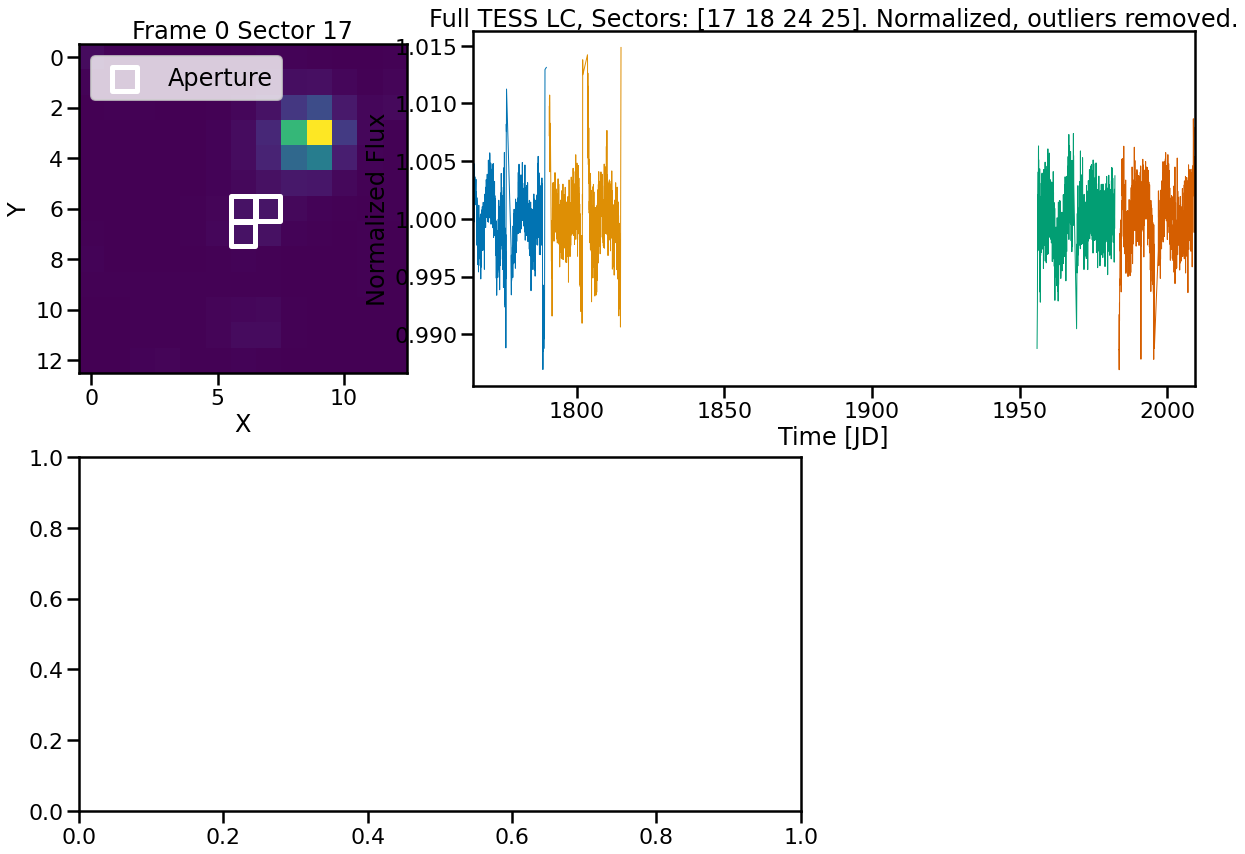

In [8]:
j.view()

- Improve period labels
- Add comparison plot at end
- Add consolidator
- Pickle the void

In [ ]:
import numpy as np
any(np.diff(j.sectors) > 1)

In [ ]:
    import matplotlib.pyplot as plt
    fig, ax2 = plt.subplots(figsize=(20,20))
    fold = j.void['clc_all'].fold(period=j.results.loc['all', 'SW'])
    if len(j.sectors) >= 2:
        for s in j.sectors:
            j.void[f'clc_{s}'].fold(period=j.results.loc['all', 'SW']).scatter(s=75, label=f'Sector {s} Folded', ax=ax2, zorder=1)
    else:
        fold.scatter(ax=ax2, c='k', s=75, label='Folded LC', zorder=1)
    fold.bin(bins=int(len(fold)/50)).plot(ax=ax2, zorder=4, lw=5, label='Binned LC')
    fold.bin(bins=int(len(fold)/50)).plot(ax=ax2, zorder=3, lw=10, c='w')

    ax2.axhline(1., c='k', zorder=2, ls='-')
    ax2.set_xlim(fold.phase.min().value, fold.phase.max().value)
    ax2.legend(loc='best', fontsize=25)
    ax2.set_title(rf'All Sectors folded on Period: {j.results.loc["all", "SW"]:.2f} $\pm$ {j.results.loc["all", "e_SW"]:.2f} days')